# Importing the libraries

In [5]:
import os
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add,TFSMLayer
from zipfile import ZipFile
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

# Datasets loading

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99%|██████████████████████████████████████▌| 1.02G/1.04G [00:08<00:00, 142MB/s]
100%|███████████████████████████████████████| 1.04G/1.04G [00:08<00:00, 131MB/s]


In [3]:
with ZipFile('/kaggle/working/flickr8k.zip','r') as f:
  f.extractall()

In [6]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Extract Image Features

In [4]:
model = VGG16() # load the model

model = Model(inputs = model.inputs, outputs = model.layers[-2].output) # restructure the model

model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

# Extract the feature from Images

In [9]:
features = {}

directory = WORKING_DIR + '/Images'

for img_name in tqdm(os.listdir(directory)):

  img_path = directory + '/' + img_name

  image = load_img(img_path, target_size = (224, 224))

  image = img_to_array(image)

  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  image = preprocess_input(image)

  feature = model.predict(image, verbose=0)

  image_id = img_name.split('.')[0]

  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

# saving the features

In [ ]:
pickle.dump(features, open('/content/features.pkl', 'wb'))

In [5]:
with open('/kaggle/input/feature/features.pkl', 'rb') as f:
    features = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/feature/features.pkl'

# Load the Caption Data

In [11]:
with open(f'{WORKING_DIR}/captions.txt', 'r') as f:
  next(f)
  caption_doc = f.read()

# Creating a mapping of img to caption

In [12]:
mapping = {}
# process lines
for line in tqdm(caption_doc.split('\n')):

  token = line.split(',') # split the line by comma

  if len(line) < 2:
    continue

  image_id, caption = token[0], token[1]

  image_id = image_id.split('.')[0] # remove img extension from image_id

  caption = ''.join(caption) # convert caption to a string from list

  if image_id not in mapping:
    mapping[image_id] = []

  mapping[image_id].append(caption) # make mapping of image_id to caption


  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
len(mapping)

8091

# Preprocess text data

In [14]:
def clean(mapping):

  for key, captions in mapping.items():
    for i in range(len(captions)):

      caption = captions[i] # take one caption at a time

      caption = caption.lower() # convert to lowercase

      caption = caption.replace('[^A-Za-z]', '')  # delete all special characters

      caption = caption.replace('\s+', ' ') # remove extra spaces

      caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'  # add start & end tag to the caption

      captions[i] = caption # update the caption


In [15]:
mapping['1000268201_693b08cb0e']  # before cleaning the data

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
clean(mapping)

In [17]:
mapping['1000268201_693b08cb0e']  # after cleaning the data

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [18]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [19]:
len(all_captions)

40455

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenize the text

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
vocab_size

8313

In [23]:
# max_length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

# Train Test Split

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
val_split = int(split * 0.80)

train = image_ids[: val_split]
val_data = image_ids[val_split: split]
test = image_ids[split:]

print(len(train), len(val_data), len(test))

5824 1457 810


# Create a Data Generator

In [25]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]

      for caption in captions:

        seq = tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(seq)):

          in_seq, out_seq = seq[:i], seq[i]

          in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)

      if n == batch_size:

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        yield {'image': X1, 'text': X2}, y

        X1, X2, y = list(), list(), list()
        n = 0



# Model Creation

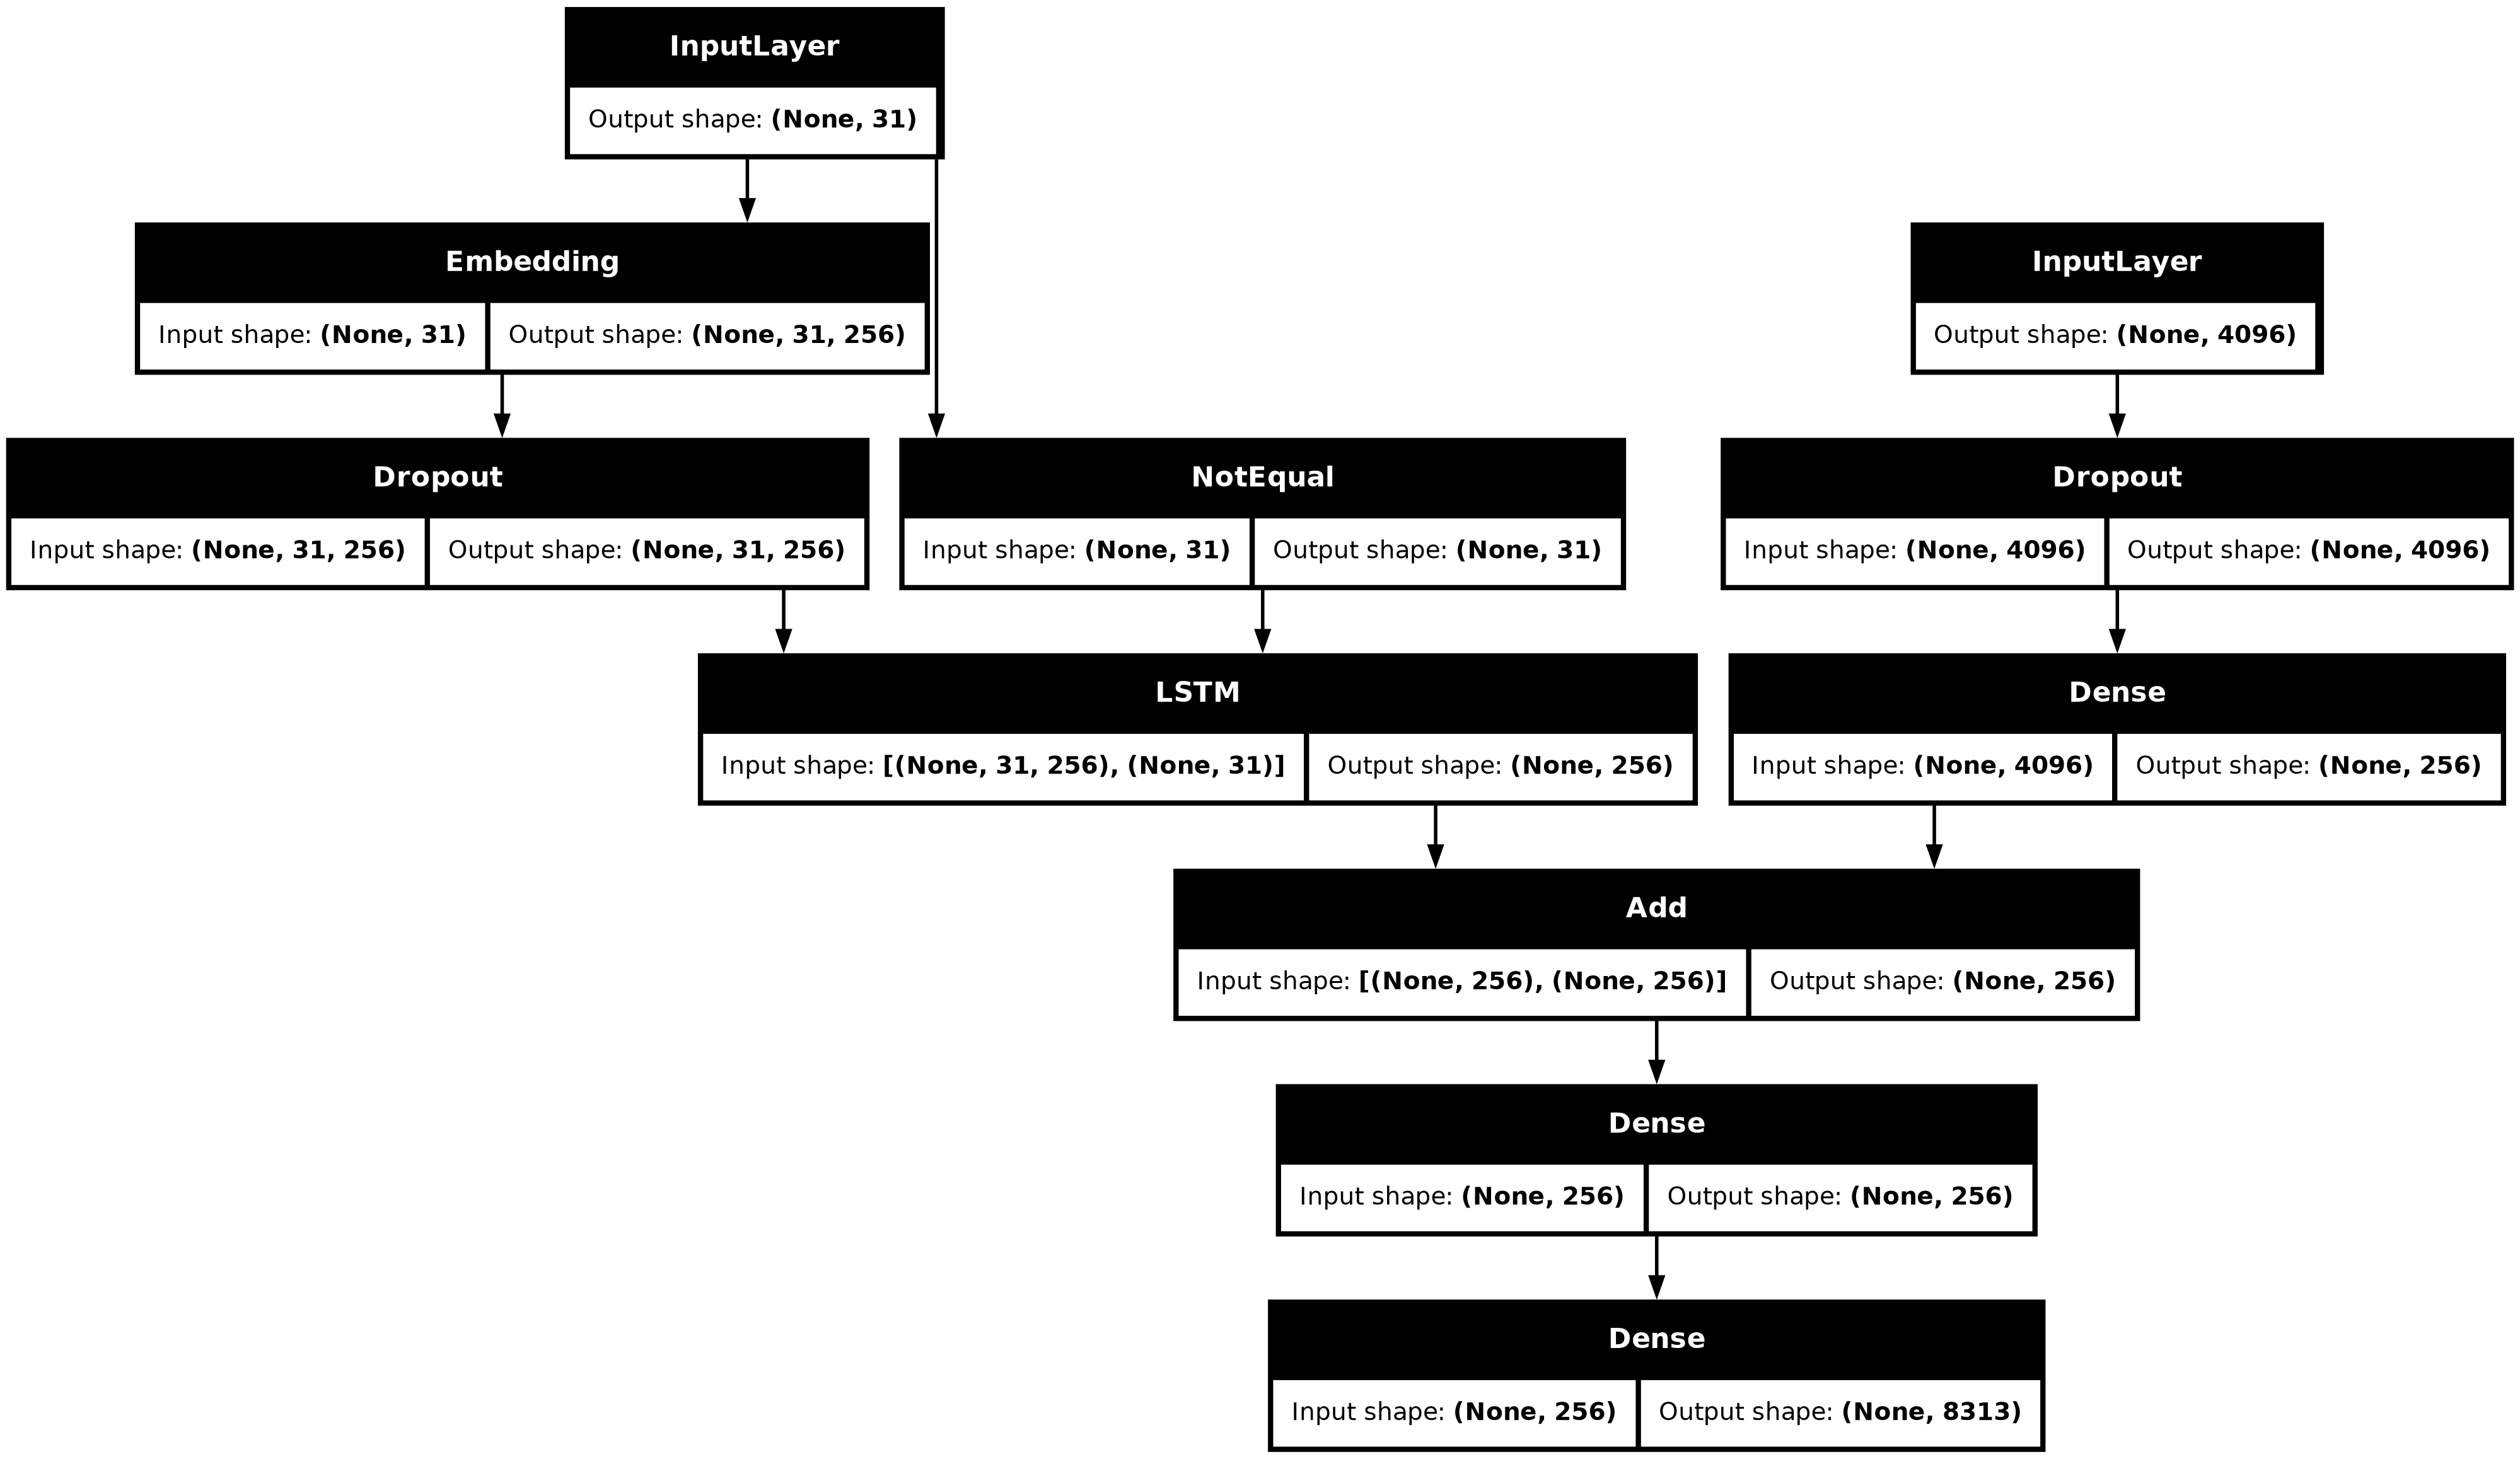

In [36]:

# encoder model
#image feature layers
inputs1 = Input(shape=(4096, ), name = 'image')
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# sequence feature layers
inputs2 = Input(shape=(max_length,), name = 'text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy')

plot_model(model, show_shapes=True)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta=0.001, 
    mode = 'auto',
    patience=4,
    restore_best_weights = True,
    verbose = 1
)

# Model Training

In [40]:
epochs=20
batch_size = 32
steps = len(train)//batch_size
validation_steps = len(val_data)//batch_size


train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(val_data, mapping, features, tokenizer, max_length, vocab_size, batch_size)

model.fit(
    train_generator,
    epochs=20,  # Train for the full number of epochs
    steps_per_epoch=steps,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[earlyStopping]
)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - loss: 4.1869 - val_loss: 4.0603
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 53s 292ms/step - loss: 3.6396 - val_loss: 3.9546
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - loss: 3.3349 - val_loss: 3.9622
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 55s 305ms/step - loss: 3.1134 - val_loss: 3.9667
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 58s 321ms/step - loss: 2.9360 - val_loss: 4.0141
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 52s 284ms/step - loss: 2.8134 - val_loss: 4.0813
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.


In [48]:
# to save model for deployment
model.save(f'{WORKING_DIR}/model.h5')

# Generate Caption

In [41]:
def idx_to_word(integer, tokenizer):

  for word, index in tokenizer.word_index.items():

    if index == integer:
      return word

  return None

In [42]:
def predict_caption(model, image, tokenizer, max_length):

  in_text = 'startseq'

  for i in range(max_length):

    sequence = tokenizer.texts_to_sequences([in_text])[0]

    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

    y_hat = model.predict([image, sequence], verbose = 0)

    y_hat = np.argmax(y_hat)

    word = idx_to_word(y_hat, tokenizer)

    if word == None:
      break

    in_text += ' ' + word

    if word == 'endseq':
      break
  return in_text

In [43]:
actual, predicted = list(), list()

for key in tqdm(test):

  captions = mapping[key]

  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  actual_caption = [caption.split() for caption in captions]
  y_pred = y_pred.split()

  actual.append(actual_caption)
  predicted.append(y_pred)

print(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}")
print(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}")

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.6042787152788923
BLEU-2: 0.3723410480044453


# Visualize the result

In [34]:
def generate_caption(image_name):

  img_id = image_name.split('.')[0]

  captions = mapping[img_id]
  image = '/kaggle/working/Images/' + image_name
  image = load_img(image)
  print('---------------------------Actual Captions---------------------------')
  for caption in captions:
    print(caption)

  y_pred = predict_caption(model, features[img_id], tokenizer, max_length)

  print('--------------------------Predicted Captions--------------------------')
  print(y_pred)
  plt.imshow(image)

---------------------------Actual Captions---------------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------------Predicted Captions--------------------------
startseq the man is sitting on the bench endseq


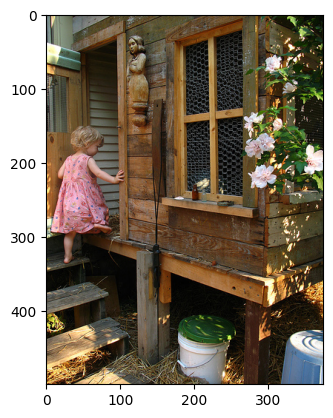

In [44]:
generate_caption('1000268201_693b08cb0e.jpg')

# Test with Real Image

In [31]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

'startseq the little girls are wearing red jerseys and yellow and yellow soccer outfit endseq'

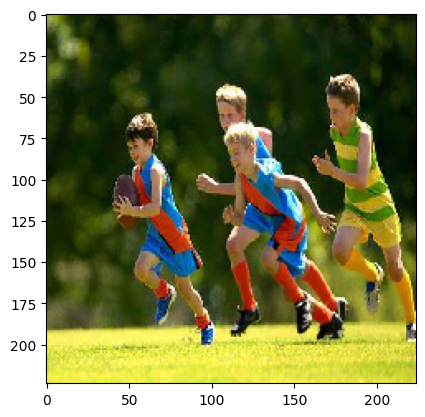

In [43]:
img_path = f'{WORKING_DIR}/OIP.jpg'

image = load_img(img_path, target_size=(224,224))
plt.imshow(image)

image = img_to_array(image)

# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))


image = preprocess_input(image)

feature = vgg_model.predict(image, verbose=0)

predict_caption(model, feature, tokenizer, max_length)

